## Pytorch version for QNN trained on Data

This code can reproduce the QNN prediction map and the Hessian distribution with pytorch.

In [ ]:
import numpy as np
from vqc_loss_landscapes.torchcirq import *
from vqc_loss_landscapes.data_helper import *

import torch
from torch.autograd import Variable
from vqc_loss_landscapes.complex import *
import qutip.qip.circuit as QCirc
from tqdm import tqdm as tqdm

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

%load_ext autoreload
%autoreload 2

In [ ]:
device = "cpu"

In [ ]:
def load_circle_data(path):
    np_file = np.load(path+".npy", allow_pickle=True)
    return np_file.item()

def test_loss(circ, params, x_train, y_train, init, measurements=None, device="cpu"):
    loss = 0.0
    i = 0
    for x,y in zip(x_train, y_train):
        # print("test loss: ", i)
        # i+=1
        y = 2*(y - 1/2)
        out1 = matmul(circ(params, x=x, device=device), init)
        out1_copy = out1.clone().detach().requires_grad_(True)
        out2 = matmul(measurements, out1)
        out1 = inner_prod(out1_copy, out2) # this is already <Psi|0><0|Psi>
        # print(out1[0])
        loss += (y-out1[0])**2
    return loss/len(x_train)

def predicted_labels(output_fidelity):
    output_labels = [np.argmax(o) for o in output_fidelity]
    return np.array(output_labels)


def prediction(params, x=None, y=None, measurements = None, device="cpu"):
    """For prediction of model measure in both directions"""
    output_fidelity = []
    for i in tqdm(range(len(x))):
        fidelities = []
        out1 = matmul(circ(params, x=x[i], device=device), init)
        out1_copy = out1.clone().detach().requires_grad_(True)
        out2 = matmul(measurements, out1)
        out1 = inner_prod(out1_copy, out2)
        fidelities.append(out1[0].detach().cpu())
        del out1
        output_fidelity.append(fidelities)
    #predicted = predicted_labels(output_fidelity)
    return output_fidelity

def get_fidelity():
    fidl= prediction(params, x=X_map, y=None, measurements = model.measures, device=device)
    c = np.array(fidl)
    fidelity = []
    for i in c[:,0]:
        fidelity.append(i.item())
    fidelity = np.array(fidelity)
    return fidelity


def plot_prediction_map(epoch):
    fidelity = get_fidelity()
    Z = fidelity.reshape(grid_resolution, grid_resolution)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cont = ax.contourf(X_grid,Y_grid,Z, 20, cmap='magma')
    plt.ylim(-1, 1)
    cont.set_clim(-0.4, 1.5)
    plt.show()
    
#============================================================================
# Mapping Parameters
# ==========================================================================
grid_resolution = 21

x_path = torch.linspace(-1,1,grid_resolution).to(device)
y_path = torch.linspace(-1,1,grid_resolution).to(device)
X_grid, Y_grid = torch.meshgrid(x_path.cpu(), y_path.cpu())

X = []
for i in range(len(x_path)):
    for j in range(len(y_path)):
        X.append([x_path[i], y_path[j], 0])
X_map = torch.tensor(X).to(device)

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = "cpu"

width = 2
layers = 4
batch_size = 16
epochs = 100
train_samples = 100
test_samples = 100
epsilon = 0

# ==========================================================================
# Data Generating
# ==========================================================================
X, y_train = generate_circle_data(train_samples)
X_train = np.zeros((train_samples,3))
X_train[:,0:2] = X[:] # add extra dim x_3 = 0
X, y_test = generate_circle_data(test_samples)
X_test = np.zeros((test_samples,3))
X_test[:,0:2] = X[:]

X_train = torch.tensor(X_train).to(device)
y_train = torch.tensor(y_train).to(device)
X_test = torch.tensor(X_test).to(device)
y_test = torch.tensor(y_test).to(device)

start training width2 layers4 epochs100
circuit built


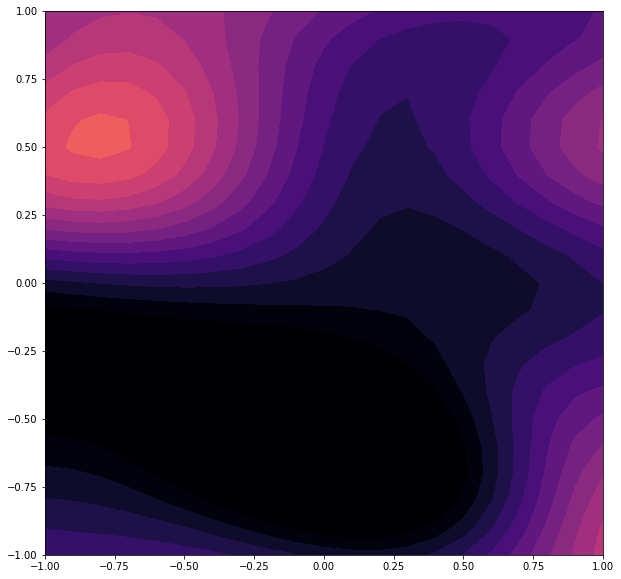

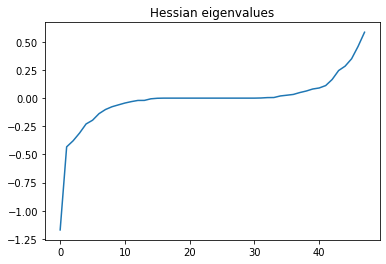

epoch:  0 batch:  0
Calc Hessian


KeyboardInterrupt: 

In [ ]:
# =================================================================================
# Main Training
# =================================================================================
print("start training width{} layers{} epochs{}".format(width, layers, epochs))
init = torch.zeros(2**width).to(device)
init[0] = 1.0 # Define initial state

init = make_complex(init)
lr = 0.1
params = torch.randn((layers, width ,2 ,3), requires_grad=True, device=device)
optimizer = torch.optim.SGD([params], lr=lr)
model = Model_Z_measure(params, width = width, layers = layers, device=device)
# circ = model.build_circuit(params, x=torch.randn((3)))

x = torch.randn((3))

circ = model.build_circuit
print("circuit built")
progress = tqdm(range(epochs), bar_format='{desc}')

loss_list = []

for i in progress:
    index = torch.randperm(len(X_train))
    plot_prediction_map(i)
    X = X_train[index][0:10] # take random sample of X and y (bc it is faster)
    y = y_train[index][0:10]
    loss = test_loss(circ, params, X, y, init, measurements=model.measures, device=device)
    ev, H = find_heigenvalues(loss, params)
    plt.plot(ev)
    plt.title("Hessian eigenvalues")
    plt.show()
    batch_idx = 0
    for Xbatch, ybatch in iterate_minibatches(X_train[index], y_train[index], batch_size=batch_size):
        if batch_idx%10 == 0:
            print("epoch: ", i, "batch: ", batch_idx)
        batch_idx += 1
        loss = test_loss(circ, params, Xbatch, ybatch, init, measurements=model.measures, device=device)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
    print("Calc Hessian")

    loss_list.append(loss.item())
    optimizer = torch.optim.SGD([params], lr=lr)
    progress.set_description_str('loss: {:3f}'.format(loss))